In [62]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import optuna


## Define constans and functions

In [63]:
locations = ["A", "B", "C"]
features_order = []

LAGGED_COLUMNS_TO_KEEP = [
    "direct_rad:W_lag_1h",
    "direct_rad:W_lag_forward_1h",
    "clear_sky_rad:W_lag_1h",
    "clear_sky_rad:W_lag_forward_1h",
    "diffuse_rad:W_lag_1h",
    "diffuse_rad:W_lag_forward_1h",
    "direct_rad_1h:J_lag_1h",
    "direct_rad_1h:J_lag_forward_1h",
    "is_in_shadow:idx_lag_1h",
    "is_in_shadow:idx_lag_forward_1h",
    "clear_sky_energy_1h:J_lag_1h",
    "clear_sky_energy_1h:J_lag_forward_1h",
    "effective_cloud_cover:p_lag_1h",
    "effective_cloud_cover:p_lag_forward_1h",
    "visibility:m_lag_1h",
    "visibility:m_lag_forward_1h",
    "total_cloud_cover:p_lag_1h",
    "total_cloud_cover:p_lag_forward_1h",
    # 'direct_rad:W_lag_2h',
    # 'direct_rad:W_lag_forward_2h',
    # 'clear_sky_rad:W_lag_2h',
    # 'clear_sky_rad:W_lag_forward_2h',
    # 'diffuse_rad:W_lag_2h',
    # 'diffuse_rad:W_lag_forward_2h',
    # 'direct_rad_1h:J_lag_2h',
    # 'direct_rad_1h:J_lag_forward_2h',
    # 'is_in_shadow:idx_lag_2h',
    # 'is_in_shadow:idx_lag_forward_2h',
    # 'clear_sky_energy_1h:J_lag_2h',
    # 'clear_sky_energy_1h:J_lag_forward_2h',
    # 'effective_cloud_cover:p_lag_2h',
    # 'effective_cloud_cover:p_lag_forward_2h',
    # 'visibility:m_lag_2h',
    # 'visibility:m_lag_forward_2h',
    # 'total_cloud_cover:p_lag_2h',
    # 'total_cloud_cover:p_lag_forward_2h',
    # 'direct_rad:W_lag_3h',
    # 'direct_rad:W_lag_forward_3h',
    # 'clear_sky_rad:W_lag_3h',
    # 'clear_sky_rad:W_lag_forward_3h',
    # 'diffuse_rad:W_lag_3h',
    # 'diffuse_rad:W_lag_forward_3h',
    # 'direct_rad_1h:J_lag_3h',
    # 'direct_rad_1h:J_lag_forward_3h',
    # 'is_in_shadow:idx_lag_3h',
    # 'is_in_shadow:idx_lag_forward_3h',
    # 'clear_sky_energy_1h:J_lag_3h',
    # 'clear_sky_energy_1h:J_lag_forward_3h',
    # 'effective_cloud_cover:p_lag_3h',
    # 'effective_cloud_cover:p_lag_forward_3h',
    # 'visibility:m_lag_3h',
    # 'visibility:m_lag_forward_3h',
    # 'total_cloud_cover:p_lag_3h',
    # 'total_cloud_cover:p_lag_forward_3h'
]

CUSTOM_COLUMNS_TO_KEEP = [
    # "hour_cos",
    # "hour_sin",
    # "month_sin",
    # "month_cos",
    "day-of-year",
]

WEATHER_FEATURES = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
]

COLUMNS_TO_PIVOT = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "is_day:idx",
    "sun_elevation:d",
    "ceiling_height_agl:m",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
    "air_density_2m:kgm3",
    "wind_speed_v_10m:ms",
    "dew_point_2m:K",
    "wind_speed_u_10m:ms",
    "t_1000hPa:K",
    "absolute_humidity_2m:gm3",
    "snow_water:kgm2",
    "relative_humidity_1000hPa:p",
    "fresh_snow_24h:cm",
    "cloud_base_agl:m",
    "fresh_snow_12h:cm",
    "snow_depth:cm",
    "dew_or_rime:idx",
    "fresh_snow_6h:cm",
    "super_cooled_liquid_water:kgm2",
    "fresh_snow_3h:cm",
    "rain_water:kgm2",
    "precip_type_5min:idx",
    "precip_5min:mm",
    "fresh_snow_1h:cm",
    "sun_azimuth:d",
    "msl_pressure:hPa",
    "pressure_100m:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa",
    "prob_rime:p",
    "wind_speed_10m:ms",
    "elevation:m",
    # "snow_density:kgm3",
    "snow_drift:idx",
    "snow_melt_10min:mm",
    "wind_speed_w_1000hPa:ms",
    # "date_calc",
]


COLUMNS_TO_KEEP = (
    [
        "direct_rad:W",
        "clear_sky_rad:W",
        "diffuse_rad:W",
        "direct_rad_1h:J",
        "is_in_shadow:idx",
        "clear_sky_energy_1h:J",
        "diffuse_rad_1h:J",
        "is_day:idx",
        "sun_elevation:d",
        # "ceiling_height_agl:m",
        "effective_cloud_cover:p",
        "visibility:m",
        "total_cloud_cover:p",
        "air_density_2m:kgm3",
        "wind_speed_v_10m:ms",
        "dew_point_2m:K",
        "wind_speed_u_10m:ms",
        "t_1000hPa:K",
        "absolute_humidity_2m:gm3",
        # "snow_water:kgm2",
        "relative_humidity_1000hPa:p",
        "fresh_snow_24h:cm",
        "cloud_base_agl:m",
        "fresh_snow_12h:cm",
        "snow_depth:cm",
        "dew_or_rime:idx",
        "fresh_snow_6h:cm",
        "super_cooled_liquid_water:kgm2",
        "fresh_snow_3h:cm",
        "rain_water:kgm2",
        "precip_type_5min:idx",
        "precip_5min:mm",
        "fresh_snow_1h:cm",
        "sun_azimuth:d",
        "msl_pressure:hPa",
        "pressure_100m:hPa",
        "pressure_50m:hPa",
        "sfc_pressure:hPa",
        "prob_rime:p",
        "wind_speed_10m:ms",
        "elevation:m",
        # "snow_density:kgm3",
        "snow_drift:idx",
        "snow_melt_10min:mm",
        "wind_speed_w_1000hPa:ms",
        # "location_A",
        # "location_B",
        # "location_C",
        # "date_calc",
        "pv_measurement",
    ]
    + CUSTOM_COLUMNS_TO_KEEP
    + LAGGED_COLUMNS_TO_KEEP
)

TEST_COLUMNS_TO_KEEP = (
    [
        "direct_rad:W",
        "clear_sky_rad:W",
        "diffuse_rad:W",
        "direct_rad_1h:J",
        "is_in_shadow:idx",
        "clear_sky_energy_1h:J",
        "diffuse_rad_1h:J",
        "is_day:idx",
        "sun_elevation:d",
        # "ceiling_height_agl:m",
        "effective_cloud_cover:p",
        "visibility:m",
        "total_cloud_cover:p",
        "air_density_2m:kgm3",
        "wind_speed_v_10m:ms",
        "dew_point_2m:K",
        "wind_speed_u_10m:ms",
        "t_1000hPa:K",
        "absolute_humidity_2m:gm3",
        "snow_water:kgm2",
        "relative_humidity_1000hPa:p",
        "fresh_snow_24h:cm",
        "cloud_base_agl:m",
        "fresh_snow_12h:cm",
        "snow_depth:cm",
        "dew_or_rime:idx",
        "fresh_snow_6h:cm",
        "super_cooled_liquid_water:kgm2",
        "fresh_snow_3h:cm",
        "rain_water:kgm2",
        "precip_type_5min:idx",
        "precip_5min:mm",
        "fresh_snow_1h:cm",
        "sun_azimuth:d",
        "msl_pressure:hPa",
        "pressure_100m:hPa",
        "pressure_50m:hPa",
        "sfc_pressure:hPa",
        "prob_rime:p",
        "wind_speed_10m:ms",
        "elevation:m",
        # "snow_density:kgm3",
        "snow_drift:idx",
        "snow_melt_10min:mm",
        "wind_speed_w_1000hPa:ms",
        # "location_A",
        # "location_B",
        # "location_C",
        # "date_calc",
        # "pv_measurement",
    ]
    + CUSTOM_COLUMNS_TO_KEEP
    + LAGGED_COLUMNS_TO_KEEP
)


CATEGORICAL_COLUMNS_BASE = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
]

# Create new categorical columns list taking into account the 15-minute interval suffixes
categorical_columns = ['location']  # 'location' presumably does not have a time suffix
for col_base in CATEGORICAL_COLUMNS_BASE[1:]:
    categorical_columns.extend([f"{col_base}_0", f"{col_base}_1", f"{col_base}_2", f"{col_base}_3"])

CATEGORICAL_COLUMNS = categorical_columns


def create_weather_lagged_features(df, weather_features):
    # Choose the weather features for which you want to create lagged versions
    for feature in weather_features:
        # Assuming hourly data, adjust the lags for your specific dataset
        # Creating lagged features for 1 hour, 1 day, and 1 week
        df[f"{feature}_lag_1h"] = df[feature].shift(1)
        # df[f'{feature}_lag_2h'] = df[feature].shift(2)
        # df[f'{feature}_lag_3h'] = df[feature].shift(3)

        df[f"{feature}_lag_forward_1h"] = df[feature].shift(-1)
        # df[f'{feature}_lag_forward_2h'] = df[feature].shift(-2)
        # df[f'{feature}_lag_forward_3h'] = df[feature].shift(-3)
        # df[f'{feature}_lag_24h'] = df[feature].shift(24*4)
        # df[f'{feature}_lag_168h'] = df[feature].shift(24 * 7 * 4 * 365)
        # df[f'{feature}_front_lag_1h'] = df[feature].shift(-4)
        # df[f'{feature}_front_lag_24h'] = df[feature].shift(-24*4)

    # Handling edges by filling NaNs with appropriate values or dropping them
    # You may choose to fill with zeroes or interpolate, based on what makes more sense for your data
    df.fillna(method="ffill", inplace=True)  # Forward fill
    df.fillna(method="bfill", inplace=True)  # Backward fill

    return df


def create_lagged_features(df, column_name="pv_measurement"):
    # Assuming 'date_forecast' is the datetime column used for sorting

    df[f"{column_name}_prev_month"] = df[column_name].shift(24 * 7)  # previous week

    # For yearly lag, you would need to calculate the number of observations per year
    # If the data is not consistent (leap years, etc.), you may need a more complex method
    # Here's a simple version assuming 365 days a year:
    df[f"{column_name}_prev_year"] = df[column_name].shift(24 * 365)  # previous year
    df[f"{column_name}_2years_ago"] = df[column_name].shift(24 * 365 * 2)  # next year

    # Handling edges by filling NaNs with appropriate values or dropping them
    df.fillna(method="ffill", inplace=True)  # Forward fill
    df.fillna(method="bfill", inplace=True)  # Backward fill

    return df

## Clean data 

In [64]:
def generate_and_save_engineered_features(estimated_parquet_file=None, output_parquet_file="engineered_data.parquet"):
    # Load main dataset, observed dataset, and target dataset
    df_merged= pd.read_parquet(estimated_parquet_file)

    print(df_merged.head())


    # Feature Engineering
    df_merged = feature_engineering(df_merged)

    # Save the engineered data
    df_merged.to_parquet(output_parquet_file)
    print(f"Engineered data saved to {output_parquet_file}")


def feature_engineering(df_merged):
    
    # 1. Time-based Features
    # df_merged['hour'] = df_merged['date_forecast'].dt.hour
    # df_merged['month'] = df_merged['date_forecast'].dt.month
    # df_merged['weekday'] = df_merged['date_forecast'].dt.weekday

    # Sinusoidal transformations for cyclical time features
    # df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged['hour'] / 24)
    # df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged['hour'] / 24)
    # df_merged['month_sin'] = np.sin(2 * np.pi * df_merged['month'] / 12)
    # df_merged['month_cos'] = np.cos(2 * np.pi * df_merged['month'] / 12)
    # df_merged['weekday_sin'] = np.sin(2 * np.pi * df_merged['weekday'] / 7)
    # df_merged['weekday_cos'] = np.cos(2 * np.pi * df_merged['weekday'] / 7)

    # Binning
    # bins = [-90, 0, 45, 90]
    # labels = ['1', '2', '3']
    # df_merged['sun_elevation_binned'] = pd.cut(df_merged['sun_elevation:d'], bins=bins, labels=labels, include_lowest=True)


    return df_merged

for location in locations:
    estimated_parquet_file_test = f"data/{location}/X_test_estimated.parquet"
    output_file_test = f"cleaned_data/{location}/X_test_engineered.parquet"
    generate_and_save_engineered_features(estimated_parquet_file=estimated_parquet_file_test, output_parquet_file=output_file_test)
    estimated_parquet_file = f"data/{location}/X_train_estimated.parquet"
    observed_parquet_file = f"data/{location}/X_train_observed.parquet"
    target_parquet_file = f"data/{location}/train_targets.parquet"
    output_file = f"cleaned_data/{location}/X_train_engineered.parquet"
    generate_and_save_engineered_features(estimated_parquet_file=estimated_parquet_file, output_parquet_file=output_file)


            date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2023-04-30 07:00:04 2023-05-01 00:00:00                       4.4   
1 2023-04-30 07:00:04 2023-05-01 00:15:00                       4.3   
2 2023-04-30 07:00:04 2023-05-01 00:30:00                       4.3   
3 2023-04-30 07:00:04 2023-05-01 00:45:00                       4.3   
4 2023-04-30 07:00:04 2023-05-01 01:00:00                       4.3   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.286            912.700012                    0.0   
1                1.287            912.700012                    0.0   
2                1.287            912.700012                    0.0   
3                1.287            912.700012                    0.0   
4                1.287                   NaN                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  ...  \
0              0.0       1041.199951              0.0      271.70001

## Prepare data


In [65]:
def add_custom_fields(df):
     df['hour_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.hour / 24)
     df['hour_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.hour / 24)

     df['month_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.month / 12)
     df['month_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.month / 12)
     df['day-of-year'] = df['date_forecast'].dt.dayofyear
     return df

def remove_outliers(df):
    # Use a mask to filter out the rows where rolling std is zero but keep the rows where the value itself is zero
    mask = (df['pv_measurement'].rolling(5).std() == 0) & (df['pv_measurement'] != 0)
    df = df[~mask]
    return df

In [66]:
pivoted_column_names = []
for col in COLUMNS_TO_PIVOT:
    if col != "pv_measurement" and col != "date_forecast":
        for slot in range(4):  # Since there are 4 slots in an hour
            pivoted_column_names.append(f"{col}_{slot}")

def create_15_minute_interval_features(df):
    # resample into hourly data by creating 15 minute intervals as columns
    # eg. unite the 4 rows for 13:00, 13:15, 13:30, 13:45 into one row
    # Convert the datetime column to a datetime object if it's not already
    df['date_forecast'] = pd.to_datetime(df['date_forecast'])

    # Create a column that indicates the 15-minute slot within the hour
    df['minute_slot'] = df['date_forecast'].dt.minute // 15

    # List the columns to pivot excluding 'date_forecast' and 'minute_slot'
    columns_to_pivot = [col for col in df.columns if col not in ['date_forecast', 'minute_slot']]

    # Pivot the dataset to have separate columns for each 15-minute slot
    df_pivoted = df.pivot_table(index=pd.Grouper(key='date_forecast', freq='H'),
                                         columns='minute_slot',
                                         values=columns_to_pivot,
                                         aggfunc='first').reset_index()

    # Flatten the multi-level column index resulting from pivot_table
    # Ensure 'date_forecast' remains intact and only append slot numbers to other columns
    new_columns = []
    for col_tuple in df_pivoted.columns:
        if col_tuple[0] == 'date_forecast':
            new_columns.append(col_tuple[0])
        else:
            column_name, minute_slot = col_tuple
            new_columns.append(f'{column_name}_{minute_slot}')

    df_pivoted.columns = new_columns

    return df_pivoted


In [67]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a dictionary to hold the scalers for each location
scalers = {}

def prepare_data(location):
    # Load data
    scaling = True  # Set scaling to True to enable individual scaling for each location
    global scalers
    global features_order

    df_observed = pd.read_parquet(f"data/{location}/X_train_observed.parquet")
    df_estimated = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")

    # Combine observed and estimated datasets
    df_combined = pd.concat([df_observed, df_estimated], axis=0).sort_values(by="date_forecast")

    df_combined = add_custom_fields(df_combined)

    df_merged = create_15_minute_interval_features(df_combined)
    

    # Merge with target data
    df_merged = pd.merge(df_merged, df_target, left_on="date_forecast", right_on="time", how="inner")
    
    # drop rows where pv_measurement is nan
    df_merged = df_merged.dropna(subset=["pv_measurement"])

    # df_merged = create_weather_lagged_features(df_merged, WEATHER_FEATURES)
    df_merged = df_merged[pivoted_column_names + ["pv_measurement"]]
    df_merged = remove_outliers(df_merged)
    
    y = df_merged["pv_measurement"]
    X = df_merged.drop("pv_measurement", axis=1)
    features_order = list(X.columns)

    # Assuming CATEGORICAL_COLUMNS is a list of the categorical column names in your DataFrame X
    X['location'] = location
    X.fillna(0, inplace=True)
    for column in CATEGORICAL_COLUMNS:
        if column in X.columns:
            X[column] = X[column].astype(str)  # Convert column to strings
            X[column] = X[column].astype('category')
            if 'missing' not in X[column].cat.categories:
                X[column] = X[column].cat.add_categories(['missing'])  # Add 'missing' as a new category.
            X[column] = X[column].fillna('missing')


    # Scaling non-categorical features if scaling is True
    if scaling:
        # Select non-categorical data types
        non_categorical_columns = X.select_dtypes(exclude=['category']).columns
        
        scalers[location] = MinMaxScaler()
        X[non_categorical_columns] = scalers[location].fit_transform(X[non_categorical_columns])

    # Assume y is already defined and needs to be transformed
    # y = np.log1p(y)
    # Return the transformed X and y
    return X, y


## Check zeros

In [68]:
import pandas as pd

def check_zeros_in_test_set(locations, data_folder="data"):
    # Dictionary to hold the count of zeros for each location
    zeros_count = {}

    # Iterate through each location
    for location in locations:
        # Load the test set data
        df_test = pd.read_parquet(f"{data_folder}/{location}/X_test_estimated.parquet")

        # Check for zeros in each column
        zeros_in_columns = (df_test == 0).sum()

        # Store the result in the dictionary
        zeros_count[location] = zeros_in_columns

    return zeros_count

# Assuming 'locations' is a list of location identifiers
locations = ["A", "B", "C"]
zero_values_summary = check_zeros_in_test_set(locations)

# Now, let's print the summary for each location
for location, zeros in zero_values_summary.items():
    print(f"Location {location}:")
    print(zeros)
    print("\n")


Location A:
date_calc                            0
date_forecast                        0
absolute_humidity_2m:gm3             0
air_density_2m:kgm3                  0
ceiling_height_agl:m                 0
clear_sky_energy_1h:J              474
clear_sky_rad:W                    595
cloud_base_agl:m                     0
dew_or_rime:idx                   2780
dew_point_2m:K                       0
diffuse_rad:W                      596
diffuse_rad_1h:J                   474
direct_rad:W                       845
direct_rad_1h:J                    650
effective_cloud_cover:p            137
elevation:m                          0
fresh_snow_12h:cm                 2878
fresh_snow_1h:cm                  2879
fresh_snow_24h:cm                 2878
fresh_snow_3h:cm                  2878
fresh_snow_6h:cm                  2878
is_day:idx                         594
is_in_shadow:idx                  2231
msl_pressure:hPa                     0
precip_5min:mm                    2696
precip_type_5

## Train

In [69]:
def train_model(X_train, y_train, X_val, y_val, location):
    cat_features = [index for index, col in enumerate(X_train.columns) if col in CATEGORICAL_COLUMNS]
    
    model = CatBoostRegressor(
        iterations=10000,
        learning_rate=0.08,
        depth=9,  # assuming you decided to keep the depth reduced
        loss_function='MAE',
        l2_leaf_reg=4,
        verbose=200,
        cat_features=cat_features,
    )

    # Use the provided validation set for early stopping
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    model.save_model(f"catboost_model_merged.cbm")

def evaluate_model(X_val, y_val, location):
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")
    
    # Unique locations in the X_val dataframe
    locations = X_val['location'].unique()
    
    for location in locations:
        # Filter X_val and y_val for the current location
        X_val_loc = X_val[X_val['location'] == location]
        y_val_loc = y_val[X_val['location'] == location]
        
        # Make predictions
        y_pred_loc = model.predict(X_val_loc)
        
        # Apply the transformation if needed (assuming y_val_loc and y_pred_loc are log1p transformed)
        y_val_loc = np.expm1(y_val_loc)
        y_pred_loc = np.expm1(y_pred_loc)
        
        # Calculate MAE for the current location
        mae = mean_absolute_error(y_val_loc, y_pred_loc)
        print(f'Location {location}, Mean Absolute Error: {mae}')


combined_X_train = pd.DataFrame()
combined_X_val = pd.DataFrame()
combined_Y_train = pd.DataFrame()
combined_Y_val = pd.DataFrame()

for location in locations:
    # Prepare the training data
    X, y = prepare_data(location)
    
    # Ensure consistent feature ordering
    features_order = list(X.columns)  # Save the feature order after preparation
    # print column with name "location_A"
    
    # Split the data once
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    combined_X_train = pd.concat([combined_X_train, X_train])
    combined_X_val = pd.concat([combined_X_val, X_val])
    combined_Y_train = pd.concat([combined_Y_train, y_train])
    combined_Y_val = pd.concat([combined_Y_val, y_val])


combined_X_train, combined_Y_train = shuffle(combined_X_train, combined_Y_train, random_state=42)
combined_X_val, combined_Y_val = shuffle(combined_X_val, combined_Y_val, random_state=42)

# Train the model using all available training data and the initial validation set for early stopping
train_model(combined_X_train, combined_Y_train, combined_X_val, combined_Y_val, location)
# Evaluate the model using the same validation set
evaluate_model(combined_X_val, combined_Y_val, location)

0:	learn: 284.1336057	test: 275.4911776	best: 275.4911776 (0)	total: 107ms	remaining: 17m 47s
200:	learn: 79.6522362	test: 81.0739549	best: 81.0739549 (200)	total: 14.5s	remaining: 11m 45s
400:	learn: 75.1273101	test: 79.2912964	best: 79.2887876 (398)	total: 28.7s	remaining: 11m 25s
600:	learn: 72.2301686	test: 78.5409131	best: 78.5409131 (600)	total: 42.9s	remaining: 11m 11s
800:	learn: 70.1038784	test: 77.9780361	best: 77.9780361 (800)	total: 57.2s	remaining: 10m 56s
1000:	learn: 68.0801654	test: 77.4368902	best: 77.4368674 (999)	total: 1m 11s	remaining: 10m 42s
1200:	learn: 66.4895852	test: 77.1966795	best: 77.1966795 (1200)	total: 1m 26s	remaining: 10m 31s
1400:	learn: 65.1226027	test: 76.9113531	best: 76.9113359 (1399)	total: 1m 41s	remaining: 10m 20s
1600:	learn: 64.0619105	test: 76.7612674	best: 76.7592051 (1596)	total: 1m 55s	remaining: 10m 7s
1800:	learn: 62.6880551	test: 76.5291372	best: 76.5247869 (1790)	total: 2m 10s	remaining: 9m 55s
2000:	learn: 61.7403193	test: 76.457208

/Users/mathiasaas/NTNU/maskinlaring/project/TDT4173-project/.venv/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: overflow encountered in expm1
  result = func(self.values, **kwargs)
/var/folders/z2/g8xyn7s12bg5v9jx9vpx997h0000gn/T/ipykernel_80459/1386616656.py:35: RuntimeWarning: overflow encountered in expm1
  y_pred_loc = np.expm1(y_pred_loc)


ValueError: Input contains infinity or a value too large for dtype('float64').

# Find optimal parameters

In [60]:

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 10000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 8, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 30),
    }

    cat_features = [index for index, col in enumerate(X_train.columns) if col in CATEGORICAL_COLUMNS]

    model = CatBoostRegressor(**params, silent=True, cat_features=cat_features)
    model.fit(combined_X_train, combined_Y_train, use_best_model=True)
    predictions = model.predict(combined_X_val)
    mae = mean_absolute_error(combined_Y_val, predictions)
    return mae

def find_optimal_hyperparameters_using_optuna():
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30)
    print('Best hyperparameters:', study.best_params)
    print('Best RMSE:', study.best_value)

# find_optimal_hyperparameters_using_optuna()

[I 2023-11-08 18:29:37,683] A new study created in memory with name: no-name-a6aa933f-bf62-441b-a24f-a81cc4e9eeef
You should provide test set for use best model. use_best_model parameter has been switched to false value.
[I 2023-11-08 18:30:15,104] Trial 0 finished with value: 0.3233827216065698 and parameters: {'iterations': 1177, 'learning_rate': 0.011365583886348897, 'depth': 8, 'subsample': 0.6245624279457929, 'colsample_bylevel': 0.6012299791770204, 'min_data_in_leaf': 67, 'l2_leaf_reg': 30}. Best is trial 0 with value: 0.3233827216065698.
You should provide test set for use best model. use_best_model parameter has been switched to false value.
[I 2023-11-08 18:31:40,568] Trial 1 finished with value: 0.3093126743231881 and parameters: {'iterations': 1195, 'learning_rate': 0.01710078620131735, 'depth': 10, 'subsample': 0.4810045747495982, 'colsample_bylevel': 0.8343728283275579, 'min_data_in_leaf': 19, 'l2_leaf_reg': 22}. Best is trial 1 with value: 0.3093126743231881.
You should p

KeyboardInterrupt: 

# Make predictions

In [70]:
def one_hot_encode_location(location, data):
    
    data['location'] = location
    data['location_A'] = (data['location'] == 'A').astype(int)
    data['location_B'] = (data['location'] == 'B').astype(int)
    data['location_C'] = (data['location'] == 'C').astype(int)

    data.drop('location', axis=1, inplace=True)
    return data


from sklearn.preprocessing import MinMaxScaler

# Assuming you have defined WEATHER_FEATURES, TEST_COLUMNS_TO_KEEP, and other functions previously

def make_predictions(df_test, location, target):
    global scalers
    scaling = True
    
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")  # Load the model specific to the location
     
    df_test = add_custom_fields(df_test)
    df_test = create_15_minute_interval_features(df_test)
    
    # One-hot encode the location
    
    # df_test = create_weather_lagged_features(df_test, WEATHER_FEATURES)
    df_test = df_test[pivoted_column_names]
    df_test.fillna(0, inplace=True)  # Consistent NaN handling with training
    df_test['location'] = location
    for column in CATEGORICAL_COLUMNS:
        if column in df_test.columns:
            df_test[column] = df_test[column].astype(str)  # Convert column to strings
            df_test[column] = df_test[column].astype('category')
            if 'missing' not in df_test[column].cat.categories:
                df_test[column] = df_test[column].cat.add_categories(['missing'])  # Add 'missing' as a new category.
            df_test[column] = df_test[column].fillna('missing')
  

    # Apply the same Min-Max normalization to the test data
    if scaling:
        
        scaler = scalers[location]
        non_categorical_columns = X.select_dtypes(exclude=['category']).columns
        df_test[non_categorical_columns] = scaler.transform(df_test[non_categorical_columns])  # Use transform, not fit_transform
        
        preds = model.predict(df_test)
        preds = np.expm1(preds)

    else:
        preds = model.predict(df_test)
        preds = np.expm1(preds)


    # Directly return predictions without inverse_transform
    return preds





## Evaluate locally


/var/folders/z2/g8xyn7s12bg5v9jx9vpx997h0000gn/T/ipykernel_80459/1573698853.py:49: RuntimeWarning: overflow encountered in expm1
  preds = np.expm1(preds)


Number of predictions that are a lower value than the actual, given that the actual is not 0: 1
Number of predictions that are larger than the target, given that the target is not 0: 470
The biggest misread is at index 6 with a difference of inf


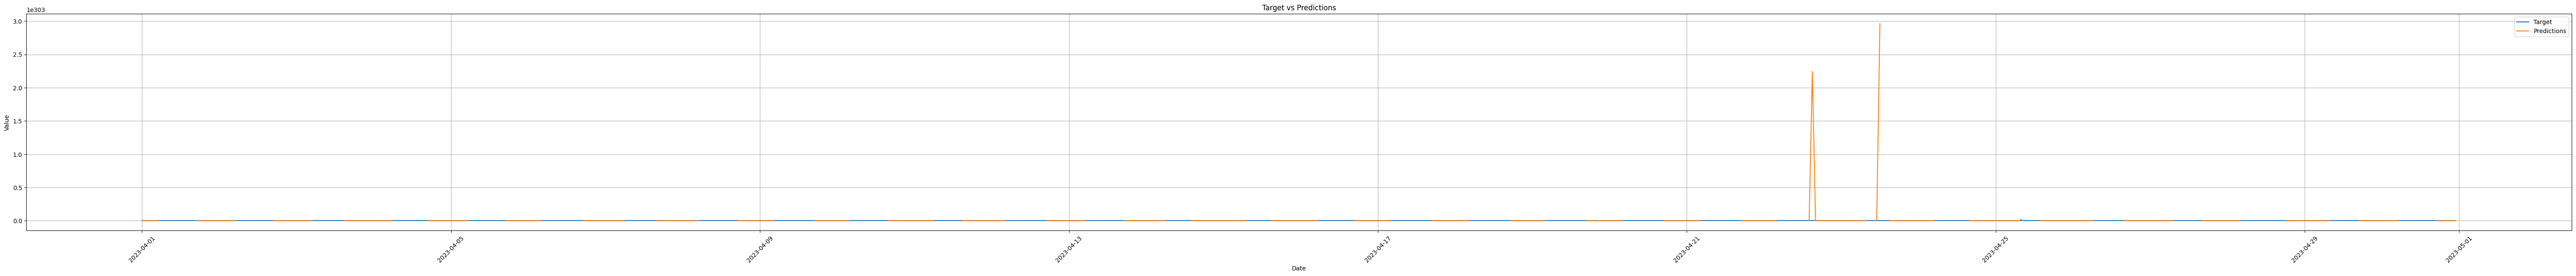

/var/folders/z2/g8xyn7s12bg5v9jx9vpx997h0000gn/T/ipykernel_80459/1573698853.py:49: RuntimeWarning: overflow encountered in expm1
  preds = np.expm1(preds)


Number of predictions that are a lower value than the actual, given that the actual is not 0: 17
Number of predictions that are larger than the target, given that the target is not 0: 444
The biggest misread is at index 106 with a difference of inf


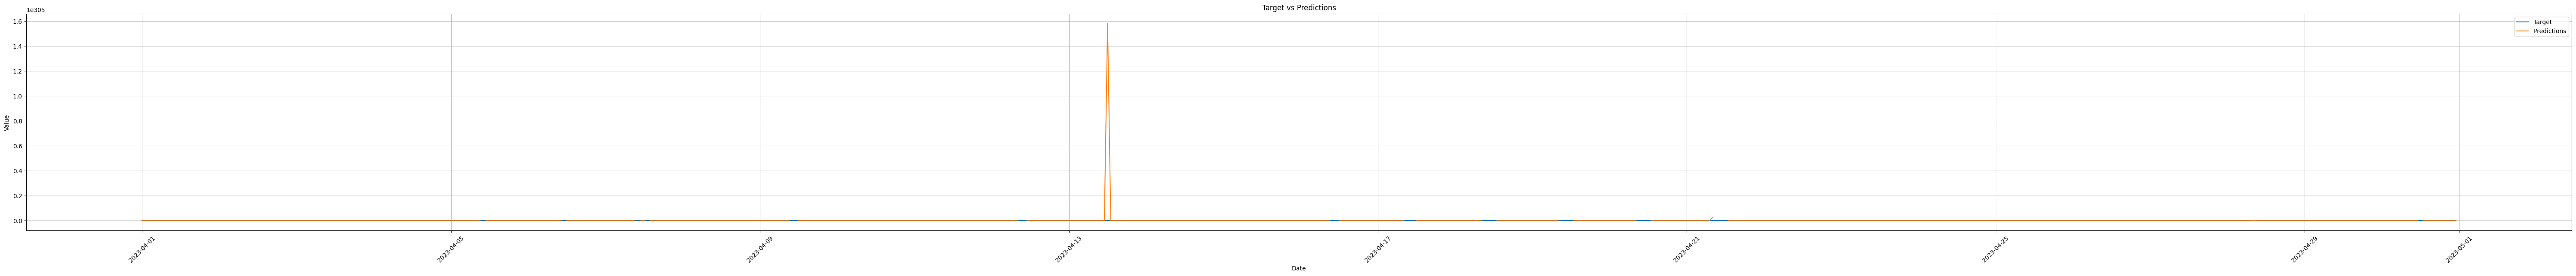

/var/folders/z2/g8xyn7s12bg5v9jx9vpx997h0000gn/T/ipykernel_80459/1573698853.py:49: RuntimeWarning: overflow encountered in expm1
  preds = np.expm1(preds)


Number of predictions that are a lower value than the actual, given that the actual is not 0: 18
Number of predictions that are larger than the target, given that the target is not 0: 437
The biggest misread is at index 658 with a difference of inf


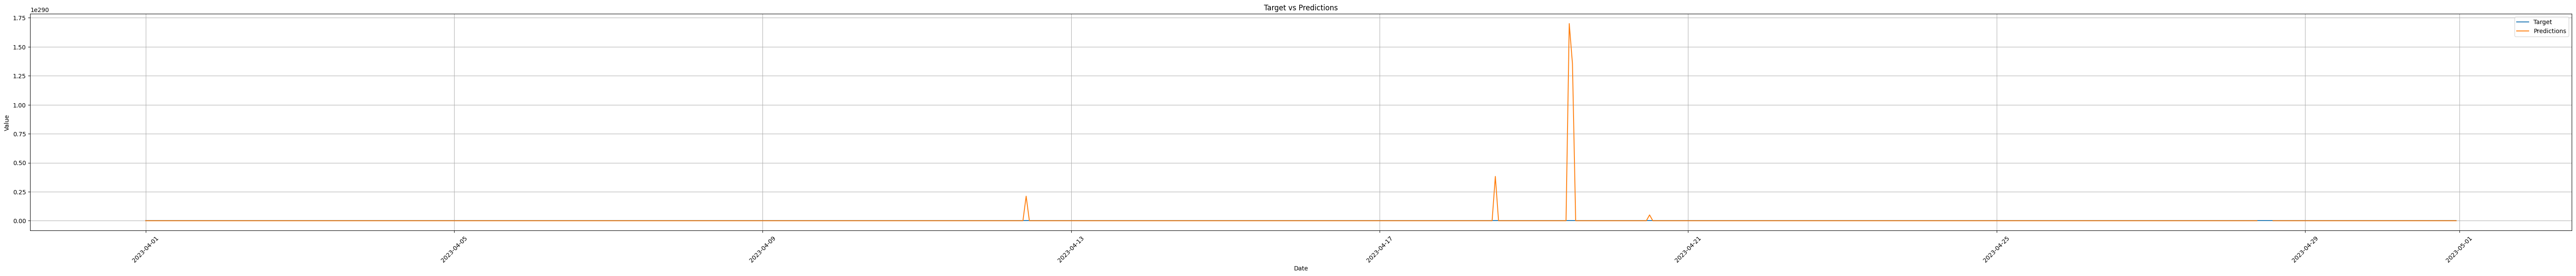

In [71]:
import matplotlib.pyplot as plt

def check_zeros_in_test_set(locations, data_folder="data"):
    # Dictionary to hold the count of zeros for each location
    zeros_count = {}

    # Iterate through each location
    for location in locations:
        # Load the test set data
        df_test = pd.read_parquet(f"{data_folder}/{location}/X_test_estimated.parquet")

        # Check for zeros in each column
        zeros_in_columns = (df_test == 0).sum()

        # Store the result in the dictionary
        zeros_count[location] = zeros_in_columns

    return zeros_count

# Assuming 'locations' is a list of location identifiers
locations = ["A", "B", "C"]
zero_values_summary = check_zeros_in_test_set(locations)


def evaluate_model_locally(location, scalers):
    # Load the test data
    target = pd.read_parquet(f"data/{location}/train_targets.parquet")
    data = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")

    # Scale the data using the scaler for the current location
    
    # Make a copy of the date_forecast column
    dates = data["date_forecast"].copy()
    # Create a new DataFrame with dates as the index
    dates_df = pd.DataFrame(index=dates).tail(720*4)

    # Resample to 1-hour intervals
    resampled_dates = dates_df.resample('1H').asfreq().index

    # Make predictions
    preds = make_predictions(data, location, target)[-720:]
    # if location in scalers:
    #     # You need to reshape preds because inverse_transform expects a 2D array
    #     preds = preds.reshape(-1, 1)
    #     preds_original_scale = scalers[location].inverse_transform(preds)

    #     # Reshape preds back to its original shape if necessary
    #     preds_original_scale = preds_original_scale.flatten()
    # mae = mean_absolute_error(target, preds)
    # print(f"Mean average Error: {mae}")
    target = target.tail(720)["pv_measurement"].to_numpy()
        # Analysis of predictions vs actual target values
    differences = preds - target
    # Count predictions lower than the actual
    lower_predictions = (differences < 0) & (target != 0)
    # Count predictions higher than the actual
    higher_predictions = (differences > 0) & (target != 0)

    # Biggest misreads
    absolute_differences = abs(differences)
    max_diff_index = absolute_differences.argmax()  # Index of the biggest difference
    max_diff_value = absolute_differences[max_diff_index]  # Value of the biggest difference

    # Printing required statistics
    print(f"Number of predictions that are a lower value than the actual, given that the actual is not 0: {lower_predictions.sum()}")
    print(f"Number of predictions that are larger than the target, given that the target is not 0: {higher_predictions.sum()}")
    print(f"The biggest misread is at index {max_diff_index} with a difference of {max_diff_value}")

    # Plotting
    plt.figure(figsize=(60,6))
    plt.plot(resampled_dates, target, label="Target")
    plt.plot(resampled_dates, preds, label="Predictions")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Target vs Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

for loc in locations:
    evaluate_model_locally(loc, scalers)


# Plot feature importance

In [30]:
def plot_feature_importance():
    plot_model = CatBoostRegressor()
    plot_model.load_model(f"catboost_15_min.cbm")  # Load the model specific to the location
    feature_importance = plot_model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(combined_X_val.columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

plot_feature_importance()


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

<Figure size 1200x600 with 0 Axes>

# Fine Tune on validation set

In [15]:
def fine_tune_on_val_set():
    # load model and train on val set
        # load model and train on val set
    # Check type of 'location' column
    cat_feat_list = [
        index_value for index_value, col in enumerate(combined_X_val.columns) if (col in CATEGORICAL_COLUMNS)
    ]


    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.005,
        depth=13,  # assuming you decided to keep the depth reduced
        loss_function="MAE",
        l2_leaf_reg=3,
        verbose=200,
        cat_features=cat_feat_list,
    )
    init_model = CatBoostRegressor()
    init_model = init_model.load_model(f"catboost_15_min.cbm")

    model.fit(combined_X_val, combined_Y_val, use_best_model=True, init_model=init_model)
    model.save_model(f"catboost_15_min_finetuned.cbm")

# fine_tune_on_val_set()

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.2498336	total: 403ms	remaining: 6m 42s
200:	learn: 0.2314139	total: 1m 17s	remaining: 5m 6s
400:	learn: 0.2159261	total: 2m 34s	remaining: 3m 50s
600:	learn: 0.2021438	total: 3m 58s	remaining: 2m 38s
800:	learn: 0.1924402	total: 5m 23s	remaining: 1m 20s
999:	learn: 0.1833107	total: 6m 48s	remaining: 0us


# Submit to csv 1

In [46]:
def round_predictions(preds, threshold=0.05):
    """
    Round values below the threshold to 0.

    Parameters:
    - preds: The predictions to round.
    - threshold: The threshold below which values are rounded down to 0.

    Returns:
    - The predictions with values rounded down to 0 below the threshold.
    """
    preds[preds < threshold] = 0
    return preds


df_submission = pd.read_csv("data/test.csv")

for location in locations: 
    df_test= pd.read_parquet(f"data/{location}/X_test_estimated.parquet")
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")
    print(len(df_test))
    
    preds = make_predictions(df_test, location, df_target)
    preds = round_predictions(preds)
    
    # Assign the predictions to df_submission for the current location
    mask = df_submission["location"] == location
    print(len(mask))
    # Before this line in your main function

    # Add a check to make sure the lengths match
    if len(preds) != mask.sum():
        print(f"Length of predictions: {len(preds)}")
        print(f"Length of submission entries: {mask.sum()}")
        raise ValueError(f"Mismatch in length of predictions and submission entries for location {location}.")

    df_submission.loc[mask, "prediction"] = preds
    

# Save the results to a new submission file
df_submission[["id", "prediction"]].to_csv("kaggle_submission_ety_tty_split.csv", index=False)

2880
2160
2880
2160
2880
2160


/var/folders/z2/g8xyn7s12bg5v9jx9vpx997h0000gn/T/ipykernel_80459/1043467628.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 0.00000000e+00 0.00000000e+00 7.03048793e+01
 2.88774383e+02 7.86711197e+02 1.90320693e+03 2.56595850e+03
 2.98238547e+03 2.56985604e+03 2.66781496e+03 2.38859819e+03
 2.54273156e+03 1.83846501e+03 2.41444676e+03 1.67615490e+03
 1.28979763e+03 6.69008767e+02 2.61807967e+02 1.56971665e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.98099995e-01 1.94893332e+02
 1.00764723e+03 2.08425045e+03 2.43319917e+03 3.05841798e+03
 4.23078177e+03 4.50190962e+03 4.48744894e+03 4.69829351e+03
 2.87986999e+03 3.38686766e+03 2.50847039e+03 2.73028534e+03
 1.77017751e+03 1.00537250e+03 4.52296335e+02 9.30878133e+01
 2.59880187e-01 0.00000000e+00 6.94670319e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.89379812e+01 2.00168541e+02
 6.284

## Submit to csv

In [139]:
df_submission = pd.read_csv("data/test.csv")

df_test_merged = pd.DataFrame()
for location in locations: 
    df_test= pd.read_parquet(f"data/{location}/X_test_estimated.parquet")
    # df_estimated = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")
    # df_observed = pd.read_parquet(f"data/{location}/X_train_observed.parquet")
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")
    # df_test = pd.concat([df_observed, df_estimated, df_test_estimated], axis=0).sort_values(
    #     by="date_forecast"
    # )
    df_test_merged = pd.concat([df_test_merged, df_test])
    

# print(df_test_merged.head())
preds = make_predictions(df_test_merged, location, df_target)
df_submission["prediction"] = preds
# Save the results to a new submission file
df_submission[["id", "prediction"]].to_csv("kaggle_submission_catboost_2.csv", index=False)

            date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2023-04-30 07:00:04 2023-05-01 00:00:00                       4.4   
1 2023-04-30 07:00:04 2023-05-01 00:15:00                       4.3   
2 2023-04-30 07:00:04 2023-05-01 00:30:00                       4.3   
3 2023-04-30 07:00:04 2023-05-01 00:45:00                       4.3   
4 2023-04-30 07:00:04 2023-05-01 01:00:00                       4.3   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.286            912.700012                    0.0   
1                1.287            912.700012                    0.0   
2                1.287            912.700012                    0.0   
3                1.287            912.700012                    0.0   
4                1.287                   NaN                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
0              0.0       1041.199951              0.0      271.700012   


ValueError: Length of values (1536) does not match length of index (2160)